# Diagnostic model
Velocity/fluidity: modelled and interpolated pre-calving velocity/fluidity from inverse model\
Geometry: post-calving\
Rift: post-calving\
Test the impact of geometry change on HC opening rate, keep velocity fixed

In [1]:
import icepack
import geojson
import numpy as np
import icepack.plot
import rasterio
from rasterio.plot import show
import firedrake
import xarray
from firedrake import Constant, inner, grad, dx
import matplotlib.pyplot as plt
import pickle
import math

In [2]:
with open("/home/sermilik/brunt_model/output_extraction_locations.pkl", "rb") as f1:
    extraction_locations = pickle.load(f1)

f1.close()

#perpendicular angles
west_angle = extraction_locations["west_angle"]
east_angle = extraction_locations["east_angle"]
#extraction points
w_n_x_2021 = extraction_locations["w_n_x_2021"]
w_n_y_2021 = extraction_locations["w_n_y_2021"]
w_s_x_2021 = extraction_locations["w_s_x_2021"]
w_s_y_2021 = extraction_locations["w_s_y_2021"]
e_n_x_2021 = extraction_locations["e_n_x_2021"]
e_n_y_2021 = extraction_locations["e_n_y_2021"]
e_s_x_2021 = extraction_locations["e_s_x_2021"]
e_s_y_2021 = extraction_locations["e_s_y_2021"]


### Geometry

In [3]:
outline = '/home/sermilik/brunt_model/d03_post_calving/brunt_HC_2021.geojson'

with open(outline,"r") as outline_file:
    outline = geojson.load(outline_file)
    
print(outline["crs"]["properties"]["name"])

urn:ogc:def:crs:EPSG::3031


In [4]:
δ = 50e3
coords = np.array(list(geojson.utils.coords(outline)))
xmin, xmax = coords[:, 0].min() - δ, coords[:, 0].max() + δ
ymin, ymax = coords[:, 1].min() - δ, coords[:, 1].max() + δ

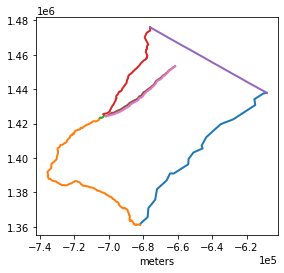

In [5]:
fig, axes = icepack.plot.subplots()

for feature in outline["features"]:
    for line_string in feature["geometry"]["coordinates"]:
        xs = np.array(line_string)
        axes.plot(xs[:, 0], xs[:, 1], linewidth=2)

axes.set_xlabel("meters");

### Imagery

In [6]:
image_filename = icepack.datasets.fetch_mosaic_of_antarctica()
image_file = rasterio.open(image_filename, "r")

transform = image_file.transform
window = rasterio.windows.from_bounds(
    left=xmin, bottom=ymin, right=xmax, top=ymax, transform=transform
)

image = image_file.read(indexes=1, window=window, masked=True)

In [7]:
def subplots(*args, **kwargs):
    fig, axes = icepack.plot.subplots()
    xmin, ymin, xmax, ymax = rasterio.windows.bounds(window, transform)
    extent = (xmin, xmax, ymin, ymax)
    axes.imshow(
        image, cmap="Greys_r", vmin=12e3, vmax=16.38e3, extent=extent
    )

    return fig, axes

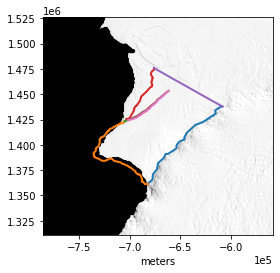

In [8]:
fig, axes = subplots()

for feature in outline["features"]:
    for line_string in feature["geometry"]["coordinates"]:
        xs = np.array(line_string)
        axes.plot(xs[:, 0], xs[:, 1], linewidth=2)

axes.set_xlabel("meters");

### Meshing

In [9]:
geometry = icepack.meshing.collection_to_geo(outline)

with open("brunt_calve_diag.geo", "w") as geo_file:
    geo_file.write(geometry.get_code())

!gmsh -2 -format msh2 -v 2 -o brunt_calve_diag.msh brunt_calve_diag.geo    
    
mesh = firedrake.Mesh("brunt_calve_diag.msh") 

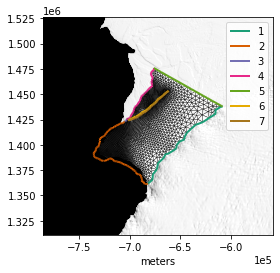

In [10]:
fig, axes = subplots()
axes.set_xlabel("meters")
kwargs = {
    "interior_kw": {"linewidth": 0.25},
    "boundary_kw": {"linewidth": 2},
}
icepack.plot.triplot(mesh, axes=axes, **kwargs)
axes.legend();

### Input data - thickness

In [11]:
thickness_filename = '/home/sermilik/brunt_model/thickness_brunt_fullcalc.tif'
thickness = rasterio.open(thickness_filename,"r")

Q = firedrake.FunctionSpace(mesh, "CG", 2)
h0 = icepack.interpolate(thickness, Q)



In [12]:
h = h0.copy(deepcopy=True)
α = firedrake.Constant(2e3)
J = 0.5 * (h - h0)**2 * dx + 0.5 * α**2 * inner(grad(h), grad(h)) * dx
F = firedrake.derivative(J, h)
firedrake.solve(F == 0, h)

### Input data - velocity

In [13]:
velocity_filename_vx = '/home/sermilik/brunt_model/d01_pre_calving/model_velocity_vx_pre_calving_err5_T253_steptol_1Eneg2_interp.tif'
velocity_filename_vy = '/home/sermilik/brunt_model/d01_pre_calving/model_velocity_vy_pre_calving_err5_T253_steptol_1Eneg2_interp.tif'

vx = rasterio.open(velocity_filename_vx, "r")
vy = rasterio.open(velocity_filename_vy, "r")

V = firedrake.VectorFunctionSpace(mesh, "CG", 2)
u0 = icepack.interpolate((vx, vy), V)


### Input data - fluidity

In [14]:
fluid_filename = '/home/sermilik/brunt_model/d01_pre_calving/fluidity_pre_calving_err5_T253_steptol_1Eneg2_interp.tif'
fluid = rasterio.open(fluid_filename,"r")

θ = icepack.interpolate(fluid, Q)

### Modeling

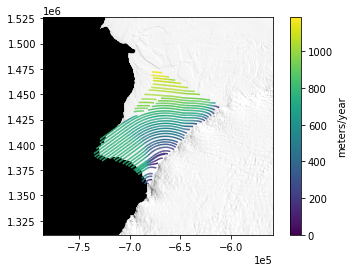

In [15]:
fig, axes = subplots()
streamlines = icepack.plot.streamplot(
    u0, precision=1000, density=2500, axes=axes
)
fig.colorbar(streamlines, label="meters/year");

In [16]:
T = Constant(253) #253
A0 = icepack.rate_factor(T)

def viscosity(**kwargs):
    u = kwargs["velocity"]
    h = kwargs["thickness"]
    θ = kwargs["log_fluidity"]

    A = A0 * firedrake.exp(θ)
    return icepack.models.viscosity.viscosity_depth_averaged(
        velocity=u, thickness=h, fluidity=A
    )


model = icepack.models.IceShelf(viscosity=viscosity)
opts = {
    "dirichlet_ids": [1, 3, 5],
    "diagnostic_solver_type": "petsc",
    "diagnostic_solver_parameters": {
        "snes_type": "newtontr",
        "ksp_type": "gmres",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
}
solver = icepack.solvers.FlowSolver(model, **opts)


In [17]:
def simulation(θ):
    return solver.diagnostic_solve(
        velocity=u0,
        thickness=h,
        log_fluidity=θ,
    )

u = simulation(θ)

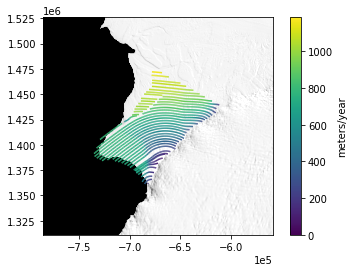

In [18]:
fig, axes = subplots()
streamlines = icepack.plot.streamplot(
    u, precision=1000, density=2500, axes=axes
)
fig.colorbar(streamlines, label="meters/year");

In [19]:
#model extract
vw_n_2021 = u((w_n_x_2021,w_n_y_2021))
vw_s_2021 = u((w_s_x_2021,w_s_y_2021))
ve_n_2021 = u((e_n_x_2021,e_n_y_2021))
ve_s_2021 = u((e_s_x_2021,e_s_y_2021))

#model magnitude
vw_n_2021_tot = np.sqrt((vw_n_2021[0]**2)+(vw_n_2021[1]**2))
vw_s_2021_tot = np.sqrt((vw_s_2021[0]**2)+(vw_s_2021[1]**2))
ve_n_2021_tot = np.sqrt((ve_n_2021[0]**2)+(ve_n_2021[1]**2))
ve_s_2021_tot = np.sqrt((ve_s_2021[0]**2)+(ve_s_2021[1]**2))

#model angle
vw_n_2021_angle = (math.atan(vw_n_2021[1]/vw_n_2021[0]))
vw_s_2021_angle = (math.atan(vw_s_2021[1]/vw_s_2021[0]))
ve_n_2021_angle = (math.atan(ve_n_2021[1]/ve_n_2021[0]))
ve_s_2021_angle = (math.atan(ve_s_2021[1]/ve_s_2021[0]))

#model offset to rift perp
vw_n_2021_offset = abs(-90-math.degrees(vw_n_2021_angle) - math.degrees(west_angle))
vw_s_2021_offset = abs(-90-math.degrees(vw_s_2021_angle) - math.degrees(west_angle))
ve_n_2021_offset = abs(-90-math.degrees(ve_n_2021_angle) - math.degrees(east_angle))
ve_s_2021_offset = abs(-90-math.degrees(ve_s_2021_angle) - math.degrees(east_angle))

#model rift perp
vw_n_2021_perp = vw_n_2021_tot * math.cos(math.radians(vw_n_2021_offset))
vw_s_2021_perp = vw_s_2021_tot * math.cos(math.radians(vw_s_2021_offset))
ve_n_2021_perp = ve_n_2021_tot * math.cos(math.radians(ve_n_2021_offset))
ve_s_2021_perp = ve_s_2021_tot * math.cos(math.radians(ve_s_2021_offset))

#model difference across rift
vdiffw_2021 = vw_n_2021_perp - vw_s_2021_perp
vdiffe_2021 = ve_n_2021_perp - ve_s_2021_perp


In [20]:
print("------------------------------")
print("Geometry: 2021")
print("Rift:     2021")
print("Velocity: Pre-calving model")
print("Model:    Pre-calving velocity, post-calving geometry rift opening rate")
print("Temp:     Diagnostic")
print("")
print("Opening rates: model")
print("Western:  "+str(round(vdiffw_2021,1))+" m/yr")
print("Eastern:  "+str(round(vdiffe_2021,1))+" m/yr")

------------------------------
Geometry: 2021
Rift:     2021
Velocity: Pre-calving model
Model:    Pre-calving velocity, post-calving geometry rift opening rate
Temp:     Diagnostic

Opening rates: model
Western:  354.1 m/yr
Eastern:  213.4 m/yr
